Charter School Missing Data Imputation and Analysis
===================================================
This code uses district level data from texas to invesitagte the incidence of learning disabilities in public and private schools.  Because the initial data had missing values (to protect identity), I first investigate the sensitivity of the data to variations of mean imputation.  I then use deterministic regression imputation to fill missing values, and compare the private and charter incidence rates graphically and statistically. 

In [3]:

%matplotlib inline
import pandas as pd
import os
import numpy as np
from sklearn import linear_model
from statsmodels.discrete.discrete_model import Poisson, NegativeBinomial
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from __future__ import division
from matplotlib.backends.backend_pdf import PdfPages

home = '/home/alex/Documents/Projects/Charter Schools/Data'
os.chdir(home)
charters = 'A1608091_CHARTER.csv'
public = 'A1608091_NON_CHARTER.csv'

def calculatePct(file,lowValue=3,impute=True):

    schoolData = pd.read_csv(file)
    schoolData = schoolData.fillna(0)
    if impute:
        schoolData = imputeMissing(schoolData)  
    else:
        schoolData = schoolData.replace(to_replace=-99,value=lowValue)
    schoolData = schoolData.reset_index(drop=True)
    dataColumns = schoolData.ix[:,'AUTISM':]
    dataColumns.columns = [colName + str('_pct') for colName in dataColumns.columns]
    calcPct = lambda x: x/schoolData['STUDENTS']
    dataColumns = dataColumns.apply(calcPct)
    schoolData = pd.merge(dataColumns,schoolData,left_index=True,right_index=True)       
    return schoolData

def getSensitivtyData(file,numbers=[1,3,5]):    
    for i in numbers:
        if i == numbers[0]:
            data = calculatePct(file,lowValue=i,impute=False)
            data['lowValue'] = i
        else:
            tempData = calculatePct(file,lowValue=i,impute=False)
            tempData['lowValue'] = i
            data = data.append(tempData)
    return data

def imputeMissing(data):
    
    schoolData = data
    schoolData['STUDENTS'] = np.log(schoolData['STUDENTS'])
    for col in schoolData.columns[4:]:
        trainingData = schoolData.loc[schoolData[col] != -99]
        missingData =  schoolData.loc[schoolData[col] == -99]
        missingData = missingData.reset_index(drop=True)
        regr = linear_model.LinearRegression()
        regr.fit((trainingData['STUDENTS'].to_frame()),(trainingData[col].to_frame()))
        imputedData = pd.DataFrame(regr.predict(missingData['STUDENTS'].to_frame()))
        imputedData.ix[:,0] = imputedData.ix[:,0].apply(lambda x: max(1,min(5,round(x))))         
        missingData[col] = imputedData
        schoolData = trainingData.append(missingData)
    schoolData['STUDENTS'] = np.exp(schoolData['STUDENTS'])  
    return schoolData

def testSensitivity(data):

    keepColumns = [u'AUTISM',
       u'EMOTIONAL_DISTURBANCE', u'INTELLECTUAL_DISABILITY',
       u'LEARNING_DISABILITY', u'ORTHOPEDIC_IMPAIRMENT',
       u'OTHER_HEALTH_IMPAIRMENT', u'SPEECH_IMPAIRMENT',
       u'AUDITORY_IMPAIRMENT', u'TRAUMATIC_BRAIN_INJURY', u'VISUAL_IMPAIRMENT',
       u'NONCATEGORICAL_EARLY_CHILDHOOD', u'DEAF_BLIND']

    for col in keepColumns:
        modelP = Poisson(data[col],data['lowValue'])
        resultsP = modelP.fit()
        print(resultsP.summary())
        
        
        modelNB = NegativeBinomial(data['AUTISM_pct'],data['lowValue'])
        resultsNB = modelNB.fit()
        print(resultsNB.summary())
        
def plotSensitivity(data):
    
    keepColumns = [u'AUTISM',
       u'EMOTIONAL_DISTURBANCE', u'INTELLECTUAL_DISABILITY',
       u'LEARNING_DISABILITY', u'ORTHOPEDIC_IMPAIRMENT',
       u'OTHER_HEALTH_IMPAIRMENT', u'SPEECH_IMPAIRMENT',
       u'AUDITORY_IMPAIRMENT', u'TRAUMATIC_BRAIN_INJURY', u'VISUAL_IMPAIRMENT',
       u'NONCATEGORICAL_EARLY_CHILDHOOD', u'DEAF_BLIND']
    
    os.chdir(os.getcwd()+'/Output')
    name = [ k for k,v in locals().iteritems() if v is data]
    fileName = str(name) + ' Sensitivity'
    pp = PdfPages(fileName)
    
    for col in keepColumns:
        g = sns.FacetGrid(data, col='lowValue')  
        print(g.map(sns.distplot, col))
        pp.savefig()
        
    pp.close()
    os.chdir(home)
    
def plotIncidenceRates(charterData,publicData,norm=True):
    
    columns = [u'AUTISM_pct', u'EMOTIONAL_DISTURBANCE_pct',
       u'INTELLECTUAL_DISABILITY_pct', u'LEARNING_DISABILITY_pct',
       u'ORTHOPEDIC_IMPAIRMENT_pct', u'OTHER_HEALTH_IMPAIRMENT_pct',
       u'SPEECH_IMPAIRMENT_pct', u'AUDITORY_IMPAIRMENT_pct',
       u'TRAUMATIC_BRAIN_INJURY_pct', u'VISUAL_IMPAIRMENT_pct',
       u'NONCATEGORICAL_EARLY_CHILDHOOD_pct', u'DEAF_BLIND_pct']

    
    widthList = [.02,.02,.02,.1,.005,.03,.05,.01,.005,.005,.01,.005]
    
    os.chdir(os.getcwd()+'/Output')
    pp = PdfPages('IncidenceRates')
    counter = 0
    
    for col in columns:
        width = widthList[counter]
        counter = counter + 1
        fig, ax = plt.subplots()
        sns.distplot(charterData[col], bins=np.linspace(0.0,width,25),ax=ax,kde=norm, kde_kws={'bw':'.001','label':'Charter'})
        sns.distplot(publicData[col], bins=np.linspace(0.0,width,25),ax=ax,kde=norm, kde_kws={'bw':'.001','label':'Public'})
        ax.set_xlim([0, width])
        print(fig)
        pp.savefig()
    
    pp.close()
    os.chdir(home)

Sensitivity Analysis
--------------------
Test multiple values as replacement for missing values

In [2]:
testNumbers = [1,3,5]
charterSensData = getSensitivtyData(charters,numbers=testNumbers)
publicSensData = getSensitivtyData(public,numbers=testNumbers)


testSensitivity(charterSensData)
testSensitivity(publicSensData)




Optimization terminated successfully.
         Current function value: 13.944717
         Iterations 13
                          Poisson Regression Results                          
Dep. Variable:                 AUTISM   No. Observations:                  549
Model:                        Poisson   Df Residuals:                      548
Method:                           MLE   Df Model:                            0
Date:                Mon, 26 Sep 2016   Pseudo R-squ.:                 -0.2013
Time:                        23:30:00   Log-Likelihood:                -7655.6
converged:                       True   LL-Null:                       -6372.7
                                        LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
lowValue       0.5015      0.004    126.764      0.000         0.494     0.509
Optimization terminated suc

/home/alex/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alex/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



         Current function value: 16370483265526.406250
         Iterations: 35
                          Poisson Regression Results                          
Dep. Variable:                 AUTISM   No. Observations:                 3072
Model:                        Poisson   Df Residuals:                     3071
Method:                           MLE   Df Model:                            0
Date:                Mon, 26 Sep 2016   Pseudo R-squ.:              -1.869e+11
Time:                        23:30:03   Log-Likelihood:            -5.0290e+16
converged:                      False   LL-Null:                   -2.6906e+05
                                        LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
lowValue       6.3050   8.92e-10   7.07e+09      0.000         6.305     6.305
Optimization terminated successfully.
         Curr

/home/alex/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alex/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



         Current function value: 25764341961209683827911861594550469109996892753845750440436225277952.000000
         Iterations: 35
                           Poisson Regression Results                          
Dep. Variable:     LEARNING_DISABILITY   No. Observations:                 3072
Model:                         Poisson   Df Residuals:                     3071
Method:                            MLE   Df Model:                            0
Date:                 Mon, 26 Sep 2016   Pseudo R-squ.:              -1.292e+65
Time:                         23:30:04   Log-Likelihood:            -7.9148e+70
converged:                       False   LL-Null:                   -6.1248e+05
                                         LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
lowValue      31.2636   7.11e-37    4.4e+37      0.000        31.264

/home/alex/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alex/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



         Current function value: 500135193684226469953181245767680.000000
         Iterations: 35
                          Poisson Regression Results                          
Dep. Variable:      SPEECH_IMPAIRMENT   No. Observations:                 3072
Model:                        Poisson   Df Residuals:                     3071
Method:                           MLE   Df Model:                            0
Date:                Mon, 26 Sep 2016   Pseudo R-squ.:              -4.025e+30
Time:                        23:30:06   Log-Likelihood:            -1.5364e+36
converged:                      False   LL-Null:                   -3.8174e+05
                                        LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
lowValue      15.2782   1.61e-19   9.47e+19      0.000        15.278    15.278
Optimization terminated successf

plot the distributions of each variable using different replacement values

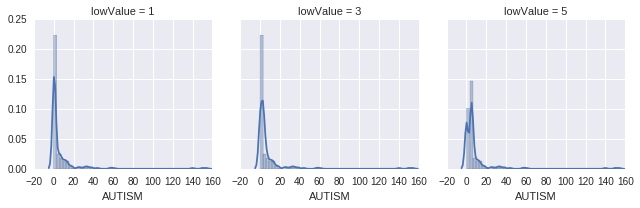

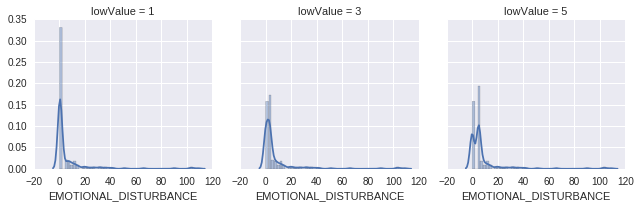

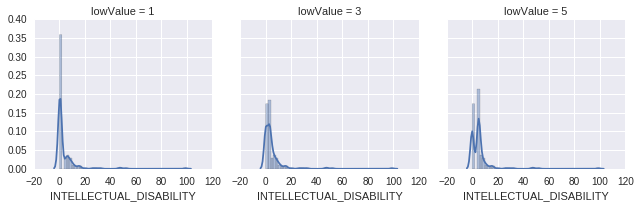

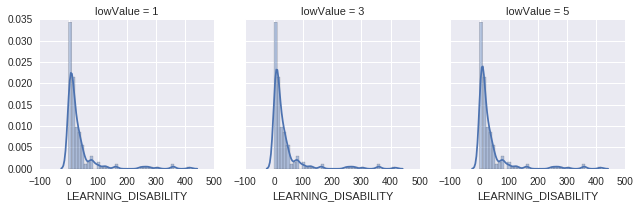

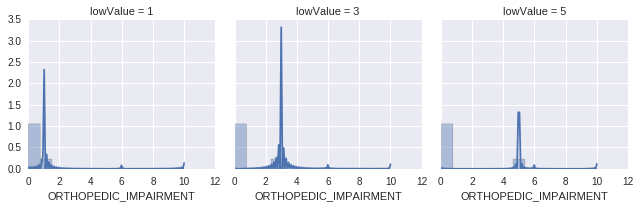

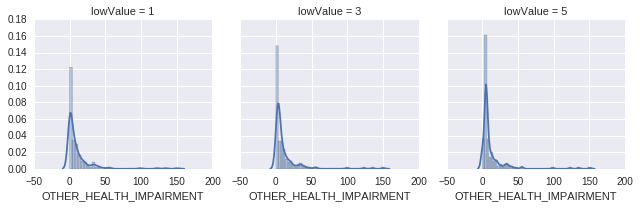

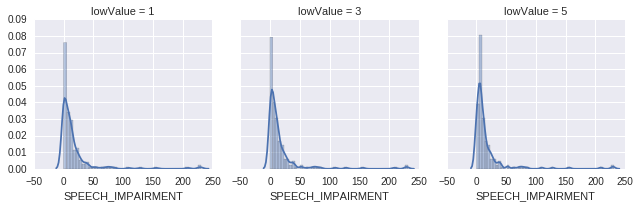

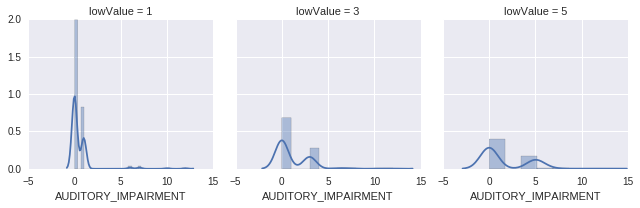

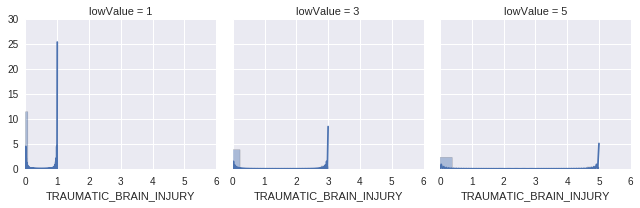

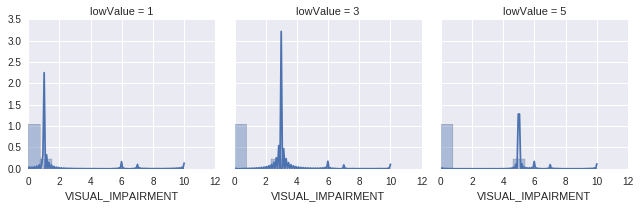

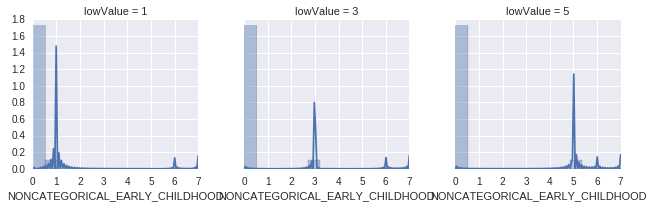

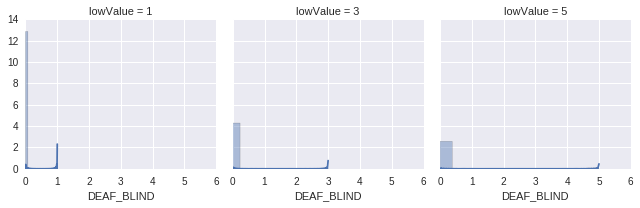

In [430]:
os.chdir('/home/alex/Documents/Projects/Charter Schools/Output')

plotSensitivity(charterSensData)

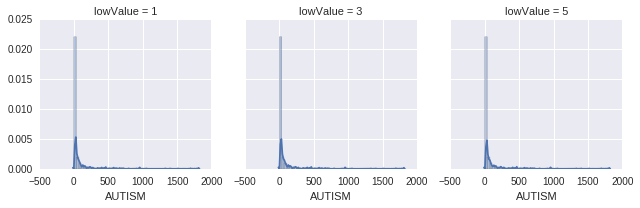

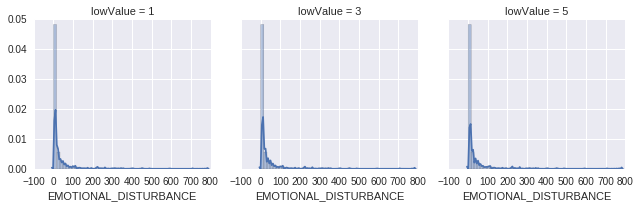

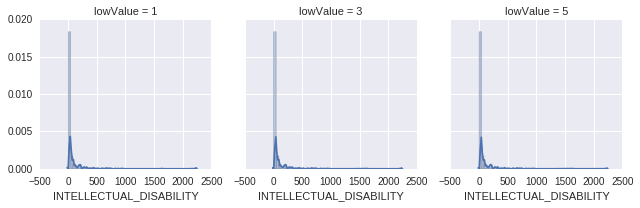

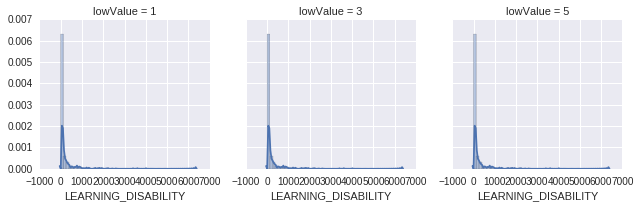

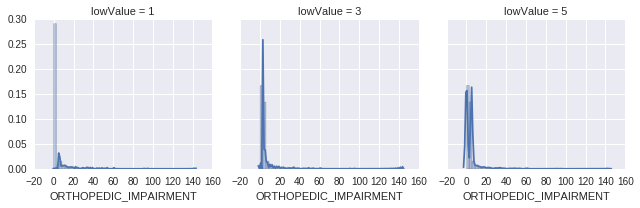

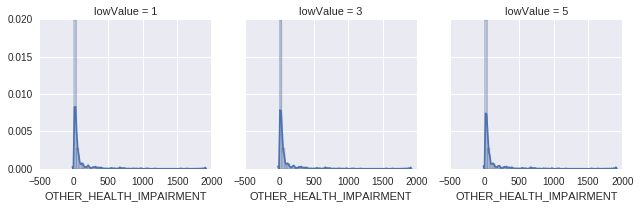

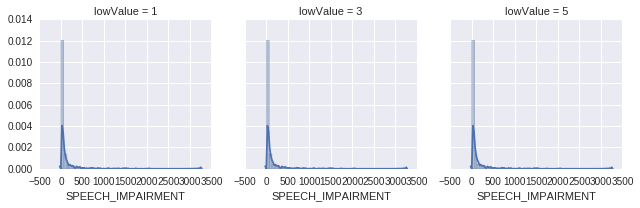

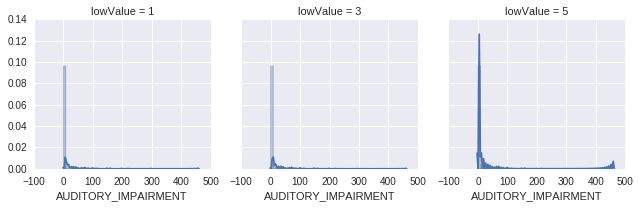

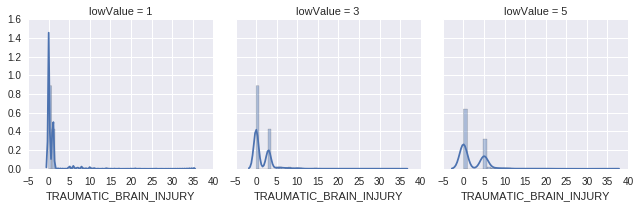

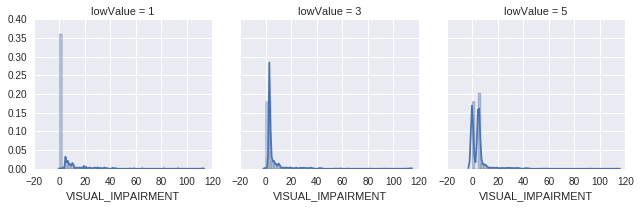

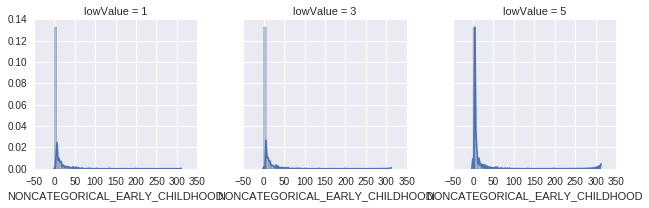

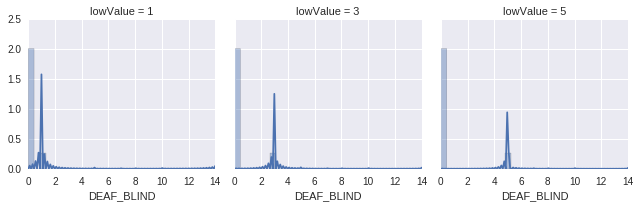

In [431]:
plotSensitivity(publicSensData)

Imputation
----
Use ***OLS*** form scikit-learn to predict values for missing data.  The *students* variable is logged.


In [5]:
charterData = calculatePct(charters)
publicData = calculatePct(public)

Analysis
--------
Plot the incidence rates for each imputed learning disability variable against each other.

Figure(480x320)
Figure(480x320)
Figure(480x320)
Figure(480x320)
Figure(480x320)
Figure(480x320)
Figure(480x320)
Figure(480x320)
Figure(480x320)
Figure(480x320)
Figure(480x320)
Figure(480x320)


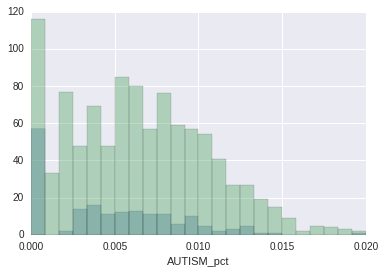

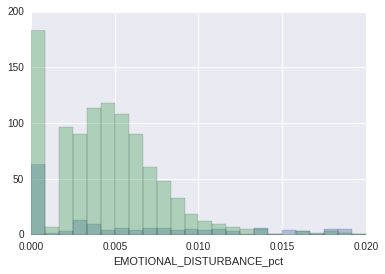

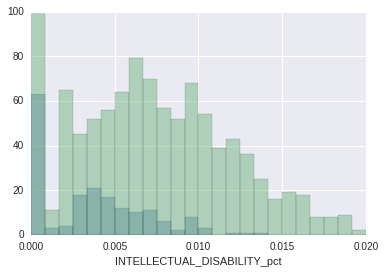

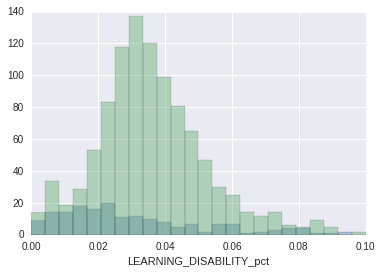

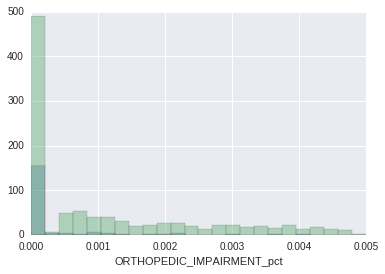

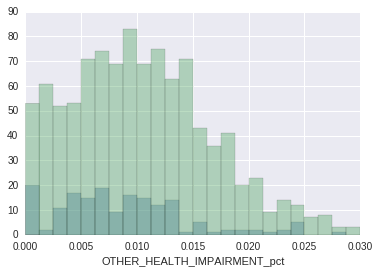

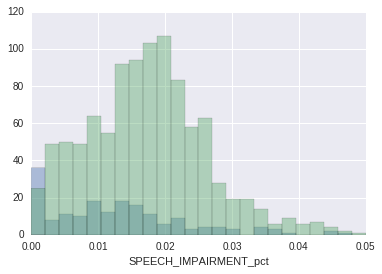

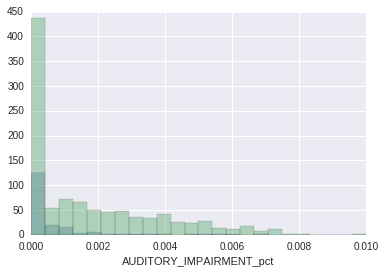

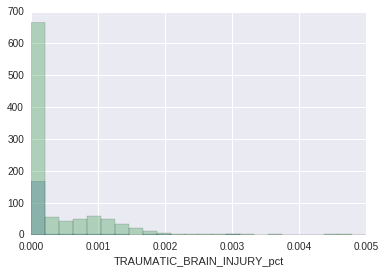

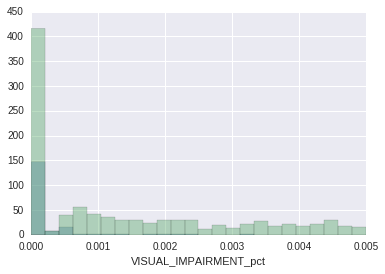

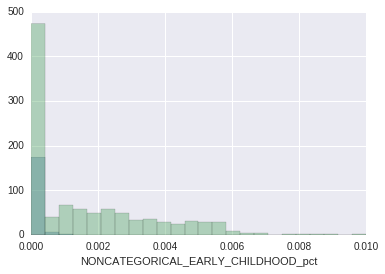

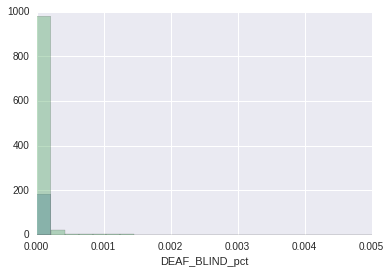

In [6]:
plotIncidenceRates(charterData,publicData, norm=False)

Calculate aggregates from the data, and compare the Public and Charter aggregates using a statistical test

In [7]:
dataTotals = pd.DataFrame(charterData.ix[:,15:].apply(np.sum, axis=0))
dataTotals.columns = ['Charter Total']
dataTotals['Percent of Charter Students'] = dataTotals.apply(lambda x : x*100 / dataTotals.iloc[0]['Charter Total'], axis=0)

dataTotals_temp = pd.DataFrame(publicData.ix[:,16:].apply(np.sum, axis=0))
dataTotals_temp.columns = ['Public Total']
dataTotals_temp['Percent of Public Students'] = dataTotals_temp.apply(lambda x : x*100 / dataTotals_temp.iloc[0]['Public Total'], axis=0)

dataTotals = pd.merge(dataTotals, dataTotals_temp, right_index=True, left_index=True)
dataTotals['Incidence Rate Ratio'] = dataTotals['Percent of Public Students']/dataTotals['Percent of Charter Students']
dataTotals['95% confidence interval'] = map(lambda x: (np.exp(np.log(x)+1.96*np.sqrt(1/len(publicData)+1/len(charterData))),np.exp(np.log(x)-1.96*np.sqrt(1/len(publicData)+1/len(charterData)))),dataTotals['Incidence Rate Ratio'])
#dataTotals

export data to file

In [401]:
os.chdir(os.getcwd()+'/Output')

In [ ]:
dataTotals.to_csv('Summary Statistics After Imputation.csv')

In [411]:
charterData.to_csv('Charter Data with Imputed Values.csv')

In [412]:
publicData.to_csv('Public Data with Imputed Values.csv')